In [1]:
import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model  import Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
data= pd.read_csv("diabetes.csv")

In [4]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [5]:
# replacing zero values with the mean of the column
data['BMI'] = data['BMI'].replace(0,data['BMI'].mean())
data['BloodPressure'] = data['BloodPressure'].replace(0,data['BloodPressure'].mean())
data['Glucose'] = data['Glucose'].replace(0,data['Glucose'].mean())
data['Insulin'] = data['Insulin'].replace(0,data['Insulin'].mean())
data['SkinThickness'] = data['SkinThickness'].replace(0,data['SkinThickness'].mean())

In [6]:
# Handling the Outliers

q = data['Pregnancies'].quantile(0.98)
# we are removing the top 2% data from the Pregnancies column
data_cleaned = data[data['Pregnancies']<q]
q = data_cleaned['BMI'].quantile(0.99)
# we are removing the top 1% data from the BMI column
data_cleaned  = data_cleaned[data_cleaned['BMI']<q]
q = data_cleaned['SkinThickness'].quantile(0.99)
# we are removing the top 1% data from the SkinThickness column
data_cleaned  = data_cleaned[data_cleaned['SkinThickness']<q]
q = data_cleaned['Insulin'].quantile(0.95)
# we are removing the top 5% data from the Insulin column
data_cleaned  = data_cleaned[data_cleaned['Insulin']<q]
q = data_cleaned['DiabetesPedigreeFunction'].quantile(0.99)
# we are removing the top 1% data from the DiabetesPedigreeFunction column
data_cleaned  = data_cleaned[data_cleaned['DiabetesPedigreeFunction']<q]
q = data_cleaned['Age'].quantile(0.99)
# we are removing the top 1% data from the Age column
data_cleaned  = data_cleaned[data_cleaned['Age']<q]

In [8]:
data_cleaned

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.000000,79.799479,33.6,0.627,50,1
1,1,85.0,66.0,29.000000,79.799479,26.6,0.351,31,0
2,8,183.0,64.0,20.536458,79.799479,23.3,0.672,32,1
3,1,89.0,66.0,23.000000,94.000000,28.1,0.167,21,0
5,5,116.0,74.0,20.536458,79.799479,25.6,0.201,30,0
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.000000,180.000000,32.9,0.171,63,0
764,2,122.0,70.0,27.000000,79.799479,36.8,0.340,27,0
765,5,121.0,72.0,23.000000,112.000000,26.2,0.245,30,0
766,1,126.0,60.0,20.536458,79.799479,30.1,0.349,47,1


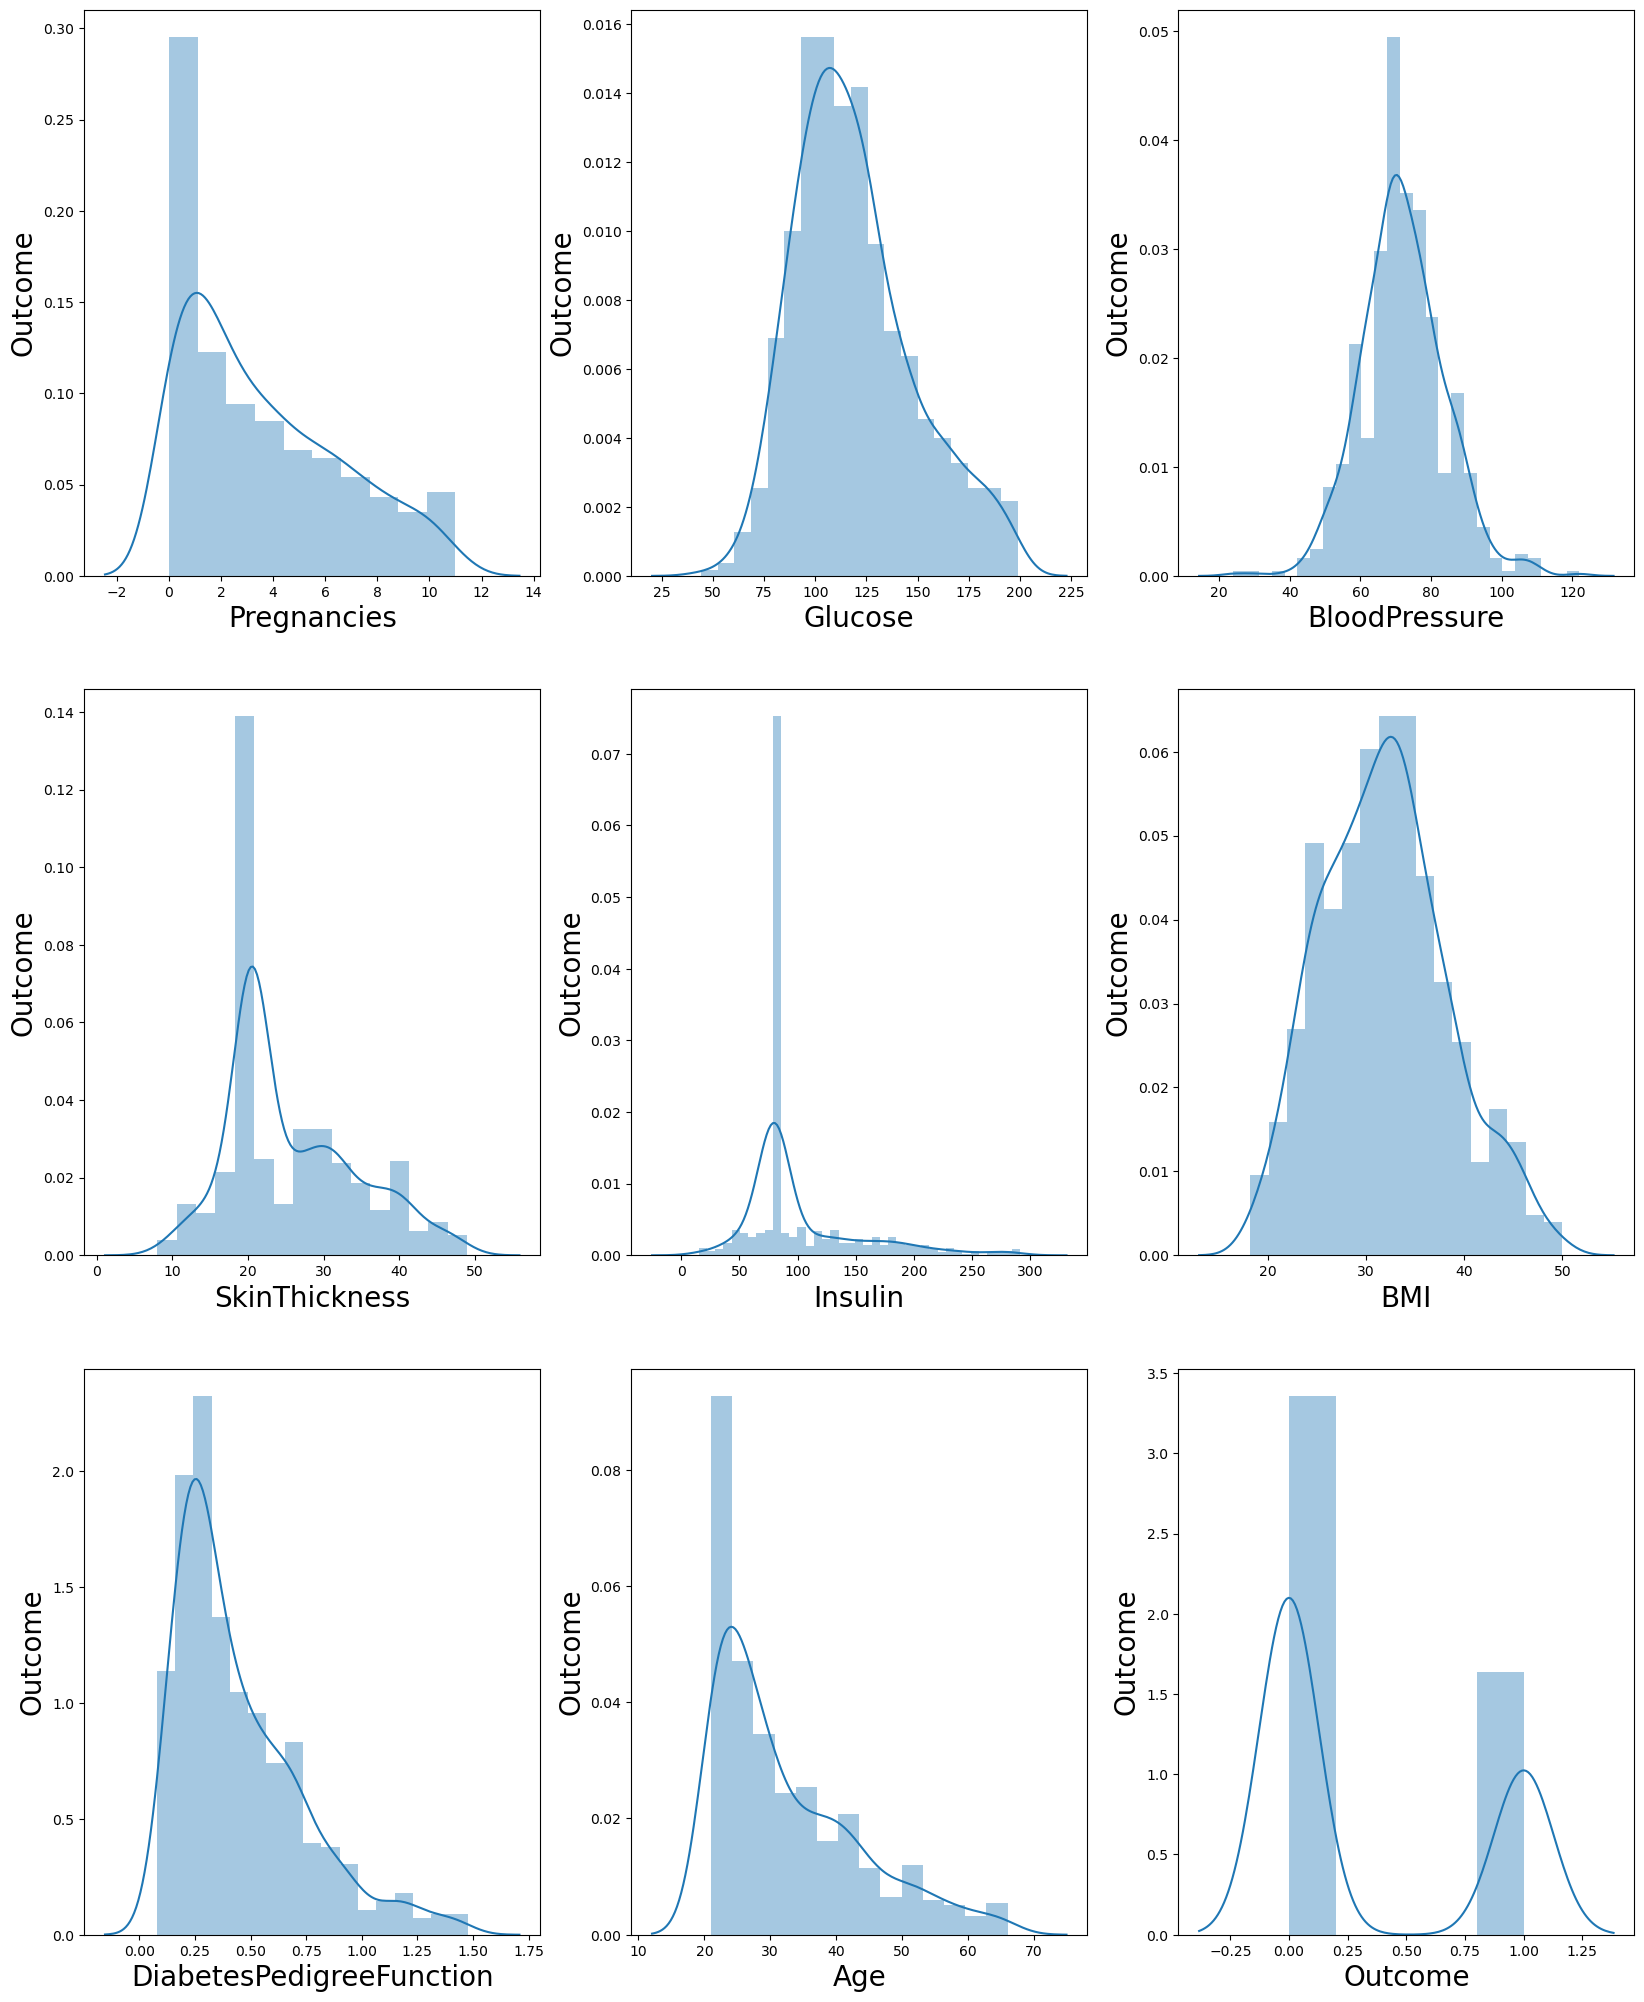

In [12]:
# let's see how data is distributed for every column
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in data_cleaned:
    if plotnumber<=9 :
        ax = plt.subplot(3,3,plotnumber)
        sns.distplot(data_cleaned[column])
        plt.xlabel(column,fontsize=20)
        plt.ylabel('Outcome',fontsize=20)
    plotnumber+=1
plt.show()

In [13]:
X = data.drop(columns = ['Outcome'])
y = data['Outcome']

In [14]:
# we need to scale our data as well

scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)

In [15]:
# This is how our data looks now after scaling.
X_scaled

array([[ 0.63994726,  0.86527574, -0.0210444 , ...,  0.16725546,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.20598931, -0.51658286, ..., -0.85153454,
        -0.36506078, -0.19067191],
       [ 1.23388019,  2.01597855, -0.68176235, ..., -1.33182125,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 , -0.02240928, -0.0210444 , ..., -0.90975111,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.14197684, -1.01212132, ..., -0.34213954,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.94297153, -0.18622389, ..., -0.29847711,
        -0.47378505, -0.87137393]])

In [16]:
# now we will check for multicollinearity using VIF(Variance Inflation factor)
vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor(X_scaled,i) for i in range(X_scaled.shape[1])]
vif["Features"] = X.columns

#let's check the values
vif

,vif,Features
0,1.431075,Pregnancies
1,1.347308,Glucose
2,1.247914,BloodPressure
3,1.450510,SkinThickness
4,1.262111,Insulin
5,1.550227,BMI
6,1.058104,DiabetesPedigreeFunction
7,1.605441,Age


In [17]:
x_train,x_test,y_train,y_test = train_test_split(X_scaled,y, test_size= 0.25, random_state = 355)

In [18]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()

In [19]:
model.fit(x_train,y_train)

GaussianNB()

In [20]:
y_pred = model.predict(x_test)

In [21]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0], dtype=int64)

In [22]:
accuracy_score(y_test, y_pred)*100

78.64583333333334

In [23]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test,y_pred)
conf_mat

array([[109,  16],
       [ 25,  42]], dtype=int64)

In [24]:
true_positive = conf_mat[0][0]
false_positive = conf_mat[0][1]
false_negative = conf_mat[1][0]
true_negative = conf_mat[1][1]

In [25]:
# Breaking down the formula for Accuracy
Accuracy = (true_positive + true_negative) / (true_positive +false_positive + false_negative + true_negative)
Accuracy

0.7864583333333334

In [26]:
# Precison
Precision = true_positive/(true_positive+false_positive)
Precision

0.872

In [27]:
# Recall
Recall = true_positive/(true_positive+false_negative)
Recall

0.8134328358208955

In [28]:
# F1 Score
F1_Score = 2*(Recall * Precision) / (Recall + Precision)
F1_Score

0.8416988416988417

In [37]:
# Area Under Curve
auc = roc_auc_score(y_test, y_pred)
auc

0.7494328358208956

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

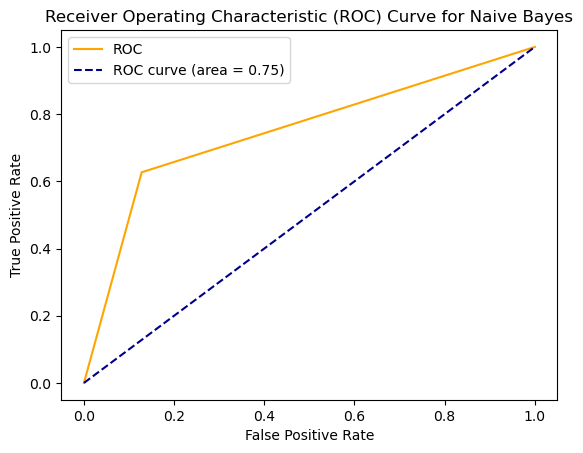

In [38]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)'% auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Naive Bayes')
plt.legend()
plt.show()

NameError: name 'auc' is not defined

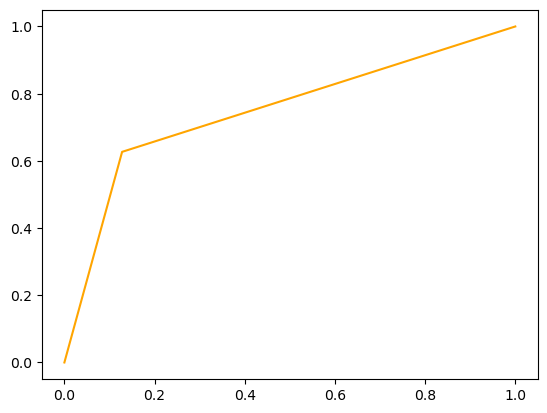

In [36]:
import matplotlib.pyplot as plt

# Assuming `fpr`, `tpr`, and `auc` are already defined

plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random Classifier (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Naive Bayes')
plt.legend(loc='lower right')
plt.show()
